# Transfer Learning on Oxford Flowers 102

## Introduction
Apply transfer learning using pre-trained CNNs—**ResNet50**, **VGG16**, and **MobileNetV2**—to classify images from the **Oxford Flowers 102** dataset.

## Project Overview
Oxford Flowers 102 contains 8,189 images across 102 flower categories. Each image is labeled with its class, and the dataset is split into training, validation, and test sets.

## Models Used
- ResNet50
- VGG16
- MobileNetV2

We'll adapt these models to classify flower species and compare their performance.

## Setup

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, models

# Enable mixed precision for speed (if GPU supports it)
mixed_precision.set_global_policy('mixed_float16')

# Hyperparameters
IMG_SIZE = (160, 160)  # Smaller for speed
BATCH_SIZE = 32
NUM_CLASSES = 102
EPOCHS = 5

AUTOTUNE = tf.data.AUTOTUNE


##  Loading Dataset



In [2]:
dataset, info = tfds.load('oxford_flowers102:2.1.1',
                          with_info=True,
                          as_supervised=True)

train_ds = dataset['train']
val_ds   = dataset['validation']
test_ds  = dataset['test']

print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.2XOFU2_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.2XOFU2_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.2XOFU2_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

## Preprocessing Function

In [3]:
def preprocess_image(image, label, model_type='mobilenetv2'):
    # Resize image
    image = tf.image.resize(image, IMG_SIZE)

    # Model-specific preprocessing
    if model_type == 'resnet50':
        image = tf.keras.applications.resnet50.preprocess_input(image)
    elif model_type == 'vgg16':
        image = tf.keras.applications.vgg16.preprocess_input(image)
    else:
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    # One-hot encode label
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def prepare_dataset(ds, model_type='mobilenetv2', shuffle=False):
    ds = ds.map(lambda x,y: preprocess_image(x,y,model_type),
                num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
    return ds

## Creating Model Builder

In [4]:
def build_model(base='mobilenetv2'):
    if base == 'resnet50':
        base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=IMG_SIZE+(3,))
    elif base == 'vgg16':
        base_model = tf.keras.applications.VGG16(weights='imagenet',
                                                 include_top=False,
                                                 input_shape=IMG_SIZE+(3,))
    else:
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                                       include_top=False,
                                                       input_shape=IMG_SIZE+(3,))

    base_model.trainable = False  # Freeze base layers

    inputs = tf.keras.Input(shape=IMG_SIZE+(3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Training Models

In [5]:
# MobileNetV2
train_mobile = prepare_dataset(train_ds, 'mobilenetv2', shuffle=True)
val_mobile = prepare_dataset(val_ds, 'mobilenetv2')
test_mobile = prepare_dataset(test_ds, 'mobilenetv2')

model_mobile = build_model('mobilenetv2')
history_mobile = model_mobile.fit(train_mobile,
                                  validation_data=val_mobile,
                                  epochs=EPOCHS)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 263s 8s/step - accuracy: 0.0272 - loss: 5.0182 - val_accuracy: 0.3882 - val_loss: 2.9870
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 205s 6s/step - accuracy: 0.5858 - loss: 2.1411 - val_accuracy: 0.6480 - val_loss: 1.8700
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.8762 - loss: 1.0365 - val_accuracy: 0.7245 - val_loss: 1.4259
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9532 - loss: 0.5728 - val_accuracy: 0.7549 - val_loss: 1.2096
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.9747 - loss: 0.3880 - val_accuracy: 0.7676 - val_loss: 1.0894


In [6]:
# ResNet50
train_resnet = prepare_dataset(train_ds, 'resnet50', shuffle=True)
val_resnet = prepare_dataset(val_ds, 'resnet50')
test_resnet = prepare_dataset(test_ds, 'resnet50')

model_resnet = build_model('resnet50')
history_resnet = model_resnet.fit(train_resnet,
                                  validation_data=val_resnet,
                                  epochs=EPOCHS)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 296s 9s/step - accuracy: 0.0585 - loss: 5.4516 - val_accuracy: 0.3853 - val_loss: 2.5836
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 305s 9s/step - accuracy: 0.6090 - loss: 1.6790 - val_accuracy: 0.6353 - val_loss: 1.5624
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - accuracy: 0.8467 - loss: 0.8030 - val_accuracy: 0.7245 - val_loss: 1.1741
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 270s 9s/step - accuracy: 0.9489 - loss: 0.3987 - val_accuracy: 0.7608 - val_loss: 1.0235
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 322s 9s/step - accuracy: 0.9736 - loss: 0.2557 - val_accuracy: 0.7725 - val_loss: 0.9418


In [10]:
# VGG16
train_vgg = prepare_dataset(train_ds, 'vgg16', shuffle=True)
val_vgg = prepare_dataset(val_ds, 'vgg16')
test_vgg = prepare_dataset(test_ds, 'vgg16')

model_vgg = build_model('vgg16')
history_vgg = model_vgg.fit(train_vgg,
                            validation_data=val_vgg,
                            epochs=EPOCHS)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 694s 22s/step - accuracy: 0.0091 - loss: 17.8731 - val_accuracy: 0.0363 - val_loss: 10.0783
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 677s 21s/step - accuracy: 0.0318 - loss: 10.8286 - val_accuracy: 0.0971 - val_loss: 7.1090
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 683s 22s/step - accuracy: 0.1057 - loss: 7.2382 - val_accuracy: 0.1784 - val_loss: 5.3279
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 689s 22s/step - accuracy: 0.2330 - loss: 5.5068 - val_accuracy: 0.2775 - val_loss: 4.0373
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 679s 22s/step - accuracy: 0.3488 - loss: 3.4626 - val_accuracy: 0.3461 - val_loss: 3.3613


## Evaluating Models

In [12]:
acc_mobile = model_mobile.evaluate(test_mobile)[1]
acc_resnet = model_resnet.evaluate(test_resnet)[1]
acc_vgg = model_vgg.evaluate(test_vgg)[1]

print(f"MobileNetV2 Test Accuracy: {acc_mobile:.2f}")
print(f"ResNet50 Test Accuracy: {acc_resnet:.2f}")
print(f"VGG16 Test Accuracy: {acc_vgg:.2f}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 619s 3s/step - accuracy: 0.7440 - loss: 1.2141
193/193 ━━━━━━━━━━━━━━━━━━━━ 848s 4s/step - accuracy: 0.7498 - loss: 1.0982
193/193 ━━━━━━━━━━━━━━━━━━━━ 2061s 11s/step - accuracy: 0.3097 - loss: 3.7814
MobileNetV2 Test Accuracy: 0.75
ResNet50 Test Accuracy: 0.75
VGG16 Test Accuracy: 0.31


## Plotting Training Curves

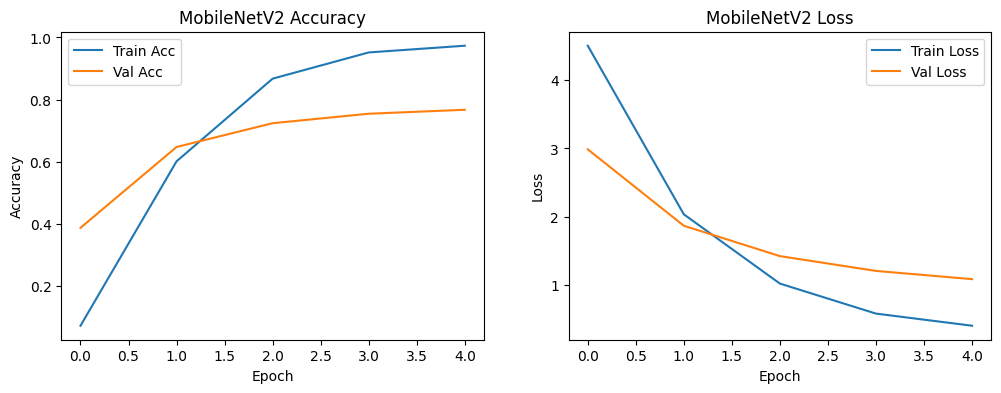

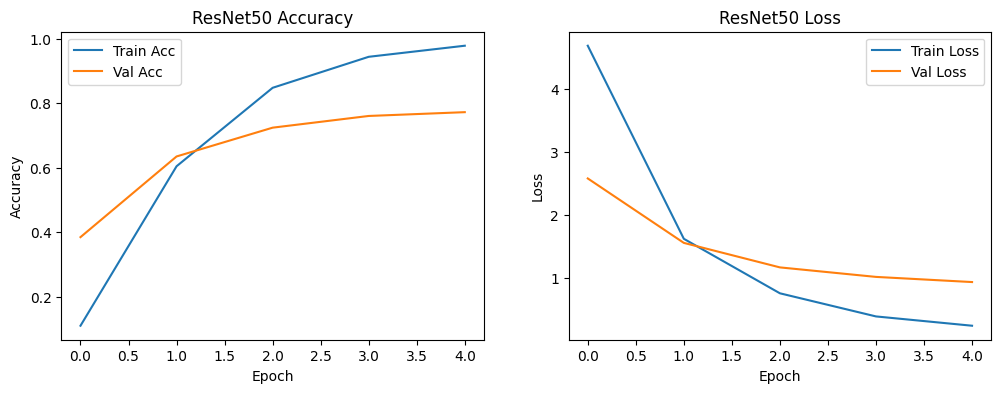

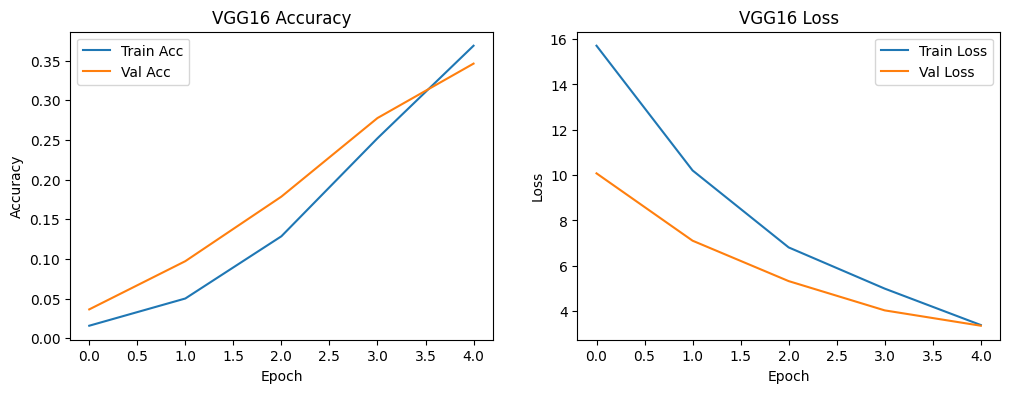

In [11]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_mobile, 'MobileNetV2')
plot_history(history_resnet, 'ResNet50')
plot_history(history_vgg, 'VGG16')

# Conclusion


1.   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
- **ResNet50** achieved the highest test accuracy at 74.9%, slightly outperforming MobileNetV2 (74.4%) and significantly surpassing VGG16 (30.9%)

2. Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
- ResNet50 and MobileNetV2 performed much better on Oxford Flowers than CIFAR-100.

- VGG16 struggled on both datasets, but especially on Oxford Flowers.
  
- There was a difference because Oxford Flowers has higher-resolution, natural images more similar to ImageNet, making transfer learning more effective.

CIFAR-100 has tiny (32x32) images with less detail, which limits the benefit of pre-trained ImageNet features.

3. Discuss the effect of transfer learning on this dataset. Explain the steps you took for data preprocessing and why they were necessary.

- Leveraged rich, pre-trained features from ImageNet and required fewer epochs and less data to converge.

- Enabled high accuracy even with limited training samples per class.

- Without transfer learning, training from scratch would likely yield much lower accuracy and slower convergence.
4. Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
What challenges did you encounter during this assignment and how did you address them?
- Resizing: Images resized to 160×160 to match model input requirements.

- Model-specific normalization: Used preprocess_input() from each architecture to scale pixel values appropriately.

- One-hot encoding: Transformed integer labels into one-hot vectors for categorical crossentropy.

- Batching, caching, prefetching: Optimized data pipeline for speed and memory efficiency.

These steps ensured compatibility with pre-trained models and efficient training.

- Challenges I faced would be waiting for the models to train because it took a significantly long time and needed a lot of patience.




